In [ ]:
import os
import sys
import gc

import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np
import cucim.skimage
import glob
from tqdm.notebook import tqdm as tqdm
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import keras_helper
import importlib
importlib.reload(keras_helper)
from keras_helper import *
from skimage.transform import resize
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model

import h5py
import cupy as cp
import math
from cupy.cuda.nvtx import RangePush, RangePop
from tqdm import tqdm
import time
import pickle
import cucim.skimage
import cucim
import random

#print(os.environ["CUDA_VISIBLE_DEVICES"])
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if len(gpus):
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      print("Restricting Memory")
  except RuntimeError as e:
    print(e)


step_set =   [18, 18, 18, 18] #Directional subsampling
mode_set =   [0, 1, 2, 3] #Irradiation point subsampling (0,1,2,3)
epoch_set =  [60, 60, 60, 60] #Number of epochs
first_set =  [0.0005, 0.0005, 0.0005, 0.0005] #First ePIE normalized error threshold
second_set = [0.0005, 0.0005, 0.0005, 0.0005] #Second ePIE normalized error threshold
round_set =  5

if not (len(step_set) == len(mode_set) == len(epoch_set) == len(first_set) == len(second_set)):
    print("Error: The variables do not match. Exiting the program.")
    sys.exit()

#Loding ptychography data
file = h5py.File("data.mat")
xscanSize, yscanSize = int(file["pyStrE"]["xscanSize"][0,0]), int(file["pyStrE"]["yscanSize"][0,0])
resolutionX, resolutionY = file["pyStrE"]["resolutionX"][0,0], file["pyStrE"]["resolutionY"][0,0]
Xsize, Ysize = file["pyStrE"]["arraySizeX"][:], file["pyStrE"]["arraySizeY"]#181*1
objArraySizeX, objArraySizeY = int(file["pyStrE"]["objArraySizeX"][0,0]), int(file["pyStrE"]["objArraySizeY"][0,0])
prbArraySizeX, prbArraySizeY = int(file["pyStrE"]["prbArraySizeX"][0,0]), int(file["pyStrE"]["prbArraySizeY"][0,0])
xList, yList = file["pyStrE"]["xList"][:], file["pyStrE"]["yList"][:] #181*11*11
alpha, beta = file["ePIEstr"]["alpha"][0,0], file["ePIEstr"]["beta"][0,0]
angle = file["angle"]
object_ini = cp.ones((181,1,629,629),dtype="complex") #全部1 #181*1*629*629
probe_ini = cp.asarray(file["probe"][:].view(np.complex128)) #ばらばら
CDIstack = cp.asarray(file["CDIstack"][:,:,:,:,:]) #181*11*11*514*514 時間かかる

#Loading test data
path = "measurement_answer"
X_test = np.load('%s/X_test.npy' %(path))
Y_I_test = np.load ('%s/Y_I_test.npy' %(path))
Y_phi_test = np.load('%s/Y_phi_test.npy' %(path))

step  = []
mode  = []
epoch = []
first_error = []
second_error = []
round_count = []
exetime = []
step1 = []
step2 = []
step3 = []
step4 = []
step5 = []
step6 = []
rmse_error = []
psnr_error =[]

for condition in range(len(step_set)):

    train_step = step_set[condition] #Directional subsampling
    train_mode = mode_set[condition] #Irradiation point subsampling (0,1,2,3)
    nepochs= epoch_set[condition] #Number of epochs
    train_normalized_error = first_set[condition] #First ePIE normalized error threshold
    final_normalized_error = second_set[condition] #Second ePIE normalized error threshold
    h,w=64,64
    path = 'result/'
    wt_path = 'result/'+'step'+str(train_step)+'_mode'+str(train_mode)+'_'+str(nepochs)+'_'+str(train_normalized_error)+'_'+str(final_normalized_error) #Where to store network weights #データの保存場所
    
    all_results =[]

    for rounds in range(round_set):

        step.append(train_step)
        mode.append(train_mode)
        epoch.append(nepochs)
        first_error.append(train_normalized_error)
        second_error.append(final_normalized_error)
        round_count.append(rounds)

        wt_path2 = str(wt_path) + '/round'+str(rounds)
        batch_size = 32

        if (not os.path.isdir(wt_path)):
            os.makedirs(wt_path)

        if (not os.path.isdir(wt_path2)):
            os.makedirs(wt_path2)

        object = object_ini[::train_step,:,:].copy()
        probe = probe_ini[::train_step,:,:].copy()
        CDIstack_cut = CDIstack[::train_step,:,:]
        num_pictures = object.shape[0]
        all_pictures = object_ini.shape[0]
        index = cp.arange(0, object_ini.shape[0], train_step)

        #Define reconstruction function
        @cp.fuse
        def inv_space_constraint(DELTAwave, CDIstack): 
            DELTAwave[:] = cp.where(CDIstack >= 0, cp.abs(CDIstack) * cp.where(cp.abs(DELTAwave) == 0, DELTAwave, DELTAwave / cp.abs(DELTAwave)), DELTAwave)

        #@cp.fuse
        def maxabs2(x): 
            return cp.max(x * cp.conj(x))

        @cp.fuse
        def update(A, coef, B, msa, DELTAwave): 
            A += (coef / msa) * cp.conj(B) * DELTAwave

        @cp.fuse 
        def rfactor_nom(CDIstack, DELTAwave_org): 
            return cp.square(cp.where(CDIstack >= 0, cp.square(CDIstack) - cp.square(cp.abs(DELTAwave_org)), 0))

        @cp.fuse
        def rfactor_denom(CDIstack):
            return cp.where(CDIstack >= 0, cp.square(cp.square(CDIstack)), 0)
        
        cp._default_memory_pool.free_all_blocks()
        cp._default_pinned_memory_pool.free_all_blocks()

        #-------------------------------- 1st ePIE -------------------------------
        start = time.time()
        First_object = []
        First_rfactors = []
        First_early_stops = []
        total_time = 0

        #Loop for the number of images
        for i in range(num_pictures):
            #Reconstruct a single image
            object_1 = object[i,0,:,:]
            probe_1 = probe[i,0,:,:]
            Xsize_1 = Xsize[i,0]
            Ysize_1 = Ysize[i,0] 
            xList_1 = xList[i,:,:] 
            yList_1 = yList[i,:,:]
            CDIstack_1 = cp.fft.fftshift(CDIstack_cut[i,:,:,:,:], axes=(2,3))

            Xa = math.floor(prbArraySizeX / 2) - math.floor(Xsize_1 / 2)
            Xb = Xa + Xsize_1
            Ya = math.floor(prbArraySizeY / 2) - math.floor(Ysize_1 / 2)
            Yb = Ya + Ysize_1
            rfactors = []
            
            with cp.cuda.Stream(non_blocking=True) as stream:     
            # Warmup run to populate FFT plan cache　
            # Generating FFT plan during CUDA graph cature results in segfault
                DELTAwave_org = cp.fft.fft2(probe_1[Xa:Xb, Ya:Yb] * object_1[:Xsize_1, :Ysize_1], norm="ortho")

                stream.begin_capture()
                
                nominator = cp.array(0.0)
                denominator = cp.array(0.0)
                probe_org = probe_1.copy()
                object_org = object_1.copy()

                for j in range(xscanSize * yscanSize):
                    Xn, Yn = divmod(j, xscanSize)    
                    X1 = int(xList_1[Yn, Xn] / resolutionX) + math.floor(objArraySizeX / 2) - math.floor(Xsize_1 / 2)
                    X2 = X1 + Xsize_1
                    Y1 = int(yList_1[Yn, Xn] / resolutionY) + math.floor(objArraySizeY / 2) - math.floor(Ysize_1 / 2)
                    Y2 = Y1 + Ysize_1

                    INwave = probe_1[Xa:Xb, Ya:Yb]
                    S_object = object_1[X1:X2, Y1:Y2]

                    # Forward propagation
                    RangePush("Forward propagation")
                    OUTwave = INwave * S_object 
                    DELTAwave = cp.fft.fft2(OUTwave, norm="ortho") 
                    RangePop()

                    # R-factor
                    RangePush("R-factor")
                    OUTWave_org = probe_org[Xa:Xb, Ya:Yb] * object_org[X1:X2, Y1:Y2]
                    DELTAwave_org = cp.fft.fft2(OUTWave_org, norm="ortho")
                    nominator += cp.sum(rfactor_nom(CDIstack_1[Yn, Xn, Xa:Xb, Ya:Yb], DELTAwave_org))
                    denominator += cp.sum(rfactor_denom(CDIstack_1[Yn, Xn, Xa:Xb, Ya:Yb]))
                    RangePop()
                    
                    # Inverse-space constraint
                    RangePush("Inverse-space constraint")
                    inv_space_constraint(DELTAwave, CDIstack_1[Yn, Xn, Xa:Xb, Ya:Yb])
                    RangePop()

                    # Backward propagation
                    RangePush("Backward propagation")
                    DELTAwave = cp.fft.ifft2(DELTAwave, norm="ortho") - OUTwave
                    S_object_old = S_object.copy()
                    update(S_object, alpha, INwave, maxabs2(INwave), DELTAwave)
                    S_object[:,:] = cp.abs(S_object) * cp.exp(1j * cp.where(cp.angle(S_object) > 0, 0, cp.angle(S_object)))
                    update(INwave, beta, S_object_old, maxabs2(S_object_old), DELTAwave)
                    RangePop()

                graph = stream.end_capture()

                for k in tqdm(range(500)):
                    graph.launch(stream)
                    stream.synchronize()
                    rfactors.append((nominator / denominator).item())
                    if (nominator/denominator).item() < train_normalized_error:
                        First_early_stops.append(k+1)
                        break
                    if k == 500:
                        First_early_stops.append(k)
                
            First_object.append(object_1)
            First_rfactors.append(rfactors)

        end = time.time()
        step1.append(end - start)
        #-----------------------------------------------------------------------------

        # 1回目再構成画像
        plt.figure()
        plt.imshow(cp.asnumpy(cp.angle(First_object[0])),cmap='viridis', vmin=-1.5,vmax=0)
        plt.colorbar()
        save_path = os.path.join(wt_path2, '1stePIE_image.png')  
        plt.savefig(save_path, dpi=800, format='png', bbox_inches='tight')  
        plt.close() 

        # 1回目正規化誤差推移
        plt.figure(figsize=(8, 6)) 
        plt.plot(First_rfactors[0][:], marker='o', linestyle='-', markersize=6, label='Normalized error')
        plt.yscale('log')  
        plt.xlabel("Iteration", fontsize=20)  
        plt.ylabel("Normalized error (log scale)", fontsize=20) 
        plt.title("Normalized error vs Iteration", fontsize=16)
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)  
        plt.tight_layout()
        save_path = os.path.join(wt_path2, 'Normalized_error_1stePIE.png') 
        plt.savefig(save_path, dpi=800, format='png', bbox_inches='tight') 
        plt.close()

        objectGuess = cp.stack(First_object).get()  
        First_object = cp.stack(First_object) 


        if rounds == 0: 
            np.save('First_object.npy', objectGuess)
            f = open(str(wt_path)+'/First_rfactors.bin', 'wb')
            pickle.dump(First_rfactors, f)
            f.close()
            f = open(str(wt_path)+'/First_object.bin', 'wb')
            pickle.dump(First_object, f)
            f.close()


        #--------------------------Create dataset--------------------------------
        print("create_dataset")
        start = time.time()
        #Preprocessing of diffraction intensity patterns
        CDIstack_red = cp.zeros((CDIstack.shape[0],CDIstack.shape[1],CDIstack.shape[2],h,w), float)
        for i in tqdm(range(CDIstack.shape[0])): 
            for j in range(CDIstack.shape[1]):
                for k in range(CDIstack.shape[2]):
                    CDIstack_red[i,j,k] = cucim.skimage.transform.resize(CDIstack[i,j,k,192:-192,192:-192],(h,w),preserve_range=True, anti_aliasing=True)

        arr_2d_list = [np.array(matrix.get()) for matrix in First_object]
        object = np.array(arr_2d_list)

        object_amp= np.abs(object).astype('float32')
        object_ph = np.angle(object).astype('float32')

        S_object_amp = np.zeros([num_pictures,xscanSize,yscanSize,514,514]).astype('float32')
        S_object_ph = np.zeros([num_pictures,xscanSize,yscanSize,514,514]).astype('float32')

        #Cropping images from phase images and amplitude images
        for i in tqdm(range(num_pictures)):
            for j in range(xscanSize * yscanSize): 
                Xn, Yn = divmod(j, xscanSize) 
                X1 = int(xList[i, Yn, Xn] / resolutionX) + math.floor(objArraySizeX / 2) - math.floor(Xsize[i,0] / 2)
                X2 = X1 + int(Xsize[i,0])
                Y1 = int(yList[i, Yn, Xn] / resolutionY) + math.floor(objArraySizeY / 2) - math.floor(Ysize[i,0] / 2)
                Y2 = Y1 + int(Ysize[i,0])
                S_object_amp[i, Xn, Yn] += object_amp[i ,X1:X2, Y1:Y2]
                S_object_ph[i, Xn, Yn] += object_ph[i, X1:X2, Y1:Y2]

        S_object_amp = cp.asarray(S_object_amp)
        S_object_ph = cp.asarray(S_object_ph)

        #Image reduction
        S_object_ph_red = cp.zeros((S_object_ph.shape[0],S_object_ph.shape[1],S_object_ph.shape[2],h,w), float) 
        S_object_amp_red = cp.zeros((S_object_ph.shape[0],S_object_ph.shape[1],S_object_ph.shape[2],h,w), float)

        for i in tqdm(range(S_object_ph.shape[0])):
            for j in range(S_object_ph.shape[1]):
                for k in range(S_object_ph.shape[2]): 
                    S_object_ph_red[i,j,k] =  cucim.skimage.transform.resize(S_object_ph[i,j,k,:,:],(h,w),preserve_range=True, anti_aliasing=True)
                    S_object_amp_red[i,j,k] = cucim.skimage.transform.resize(S_object_amp[i,j,k,:,:],(h,w),preserve_range=True, anti_aliasing=True)

        end = time.time()
        step2.append(end - start)
        #--------------------------------------------------------------------------

        print("create_Xtrain")
        if rounds == 0:
            np.save('%s/CDIstack_red'%(wt_path), CDIstack_red)
            np.save('%s/object_ph_red' %(wt_path), S_object_ph_red)
            np.save('%s/object_amp_red' %(wt_path), S_object_amp_red)

        S_object_ph_red=cp.asnumpy(S_object_ph_red)
        S_object_amp_red=cp.asnumpy(S_object_amp_red)
        CDIstack_red=cp.asnumpy(CDIstack_red)

        if train_mode == 0:
            X_train = CDIstack_red[::train_step,:,:].reshape(-1,h,w)[:,:,:,np.newaxis]
            X_test = CDIstack_red[:,:,:].reshape(-1,h,w)[:,:,:,np.newaxis]
            Y_I_train = S_object_amp_red[:,:,:].reshape(-1,h,w)[:,:,:,np.newaxis]
            Y_phi_train = S_object_ph_red[:,:,:].reshape(-1,h,w)[:,:,:,np.newaxis]
        elif train_mode == 1:
            X_train = CDIstack_red[::train_step,:,:].reshape(S_object_amp_red.shape[0],-1,64,64)
            Y_I_train = S_object_amp_red[:,:,:].reshape(S_object_amp_red.shape[0],-1,64,64)
            Y_phi_train = S_object_ph_red[:,:,:].reshape(S_object_ph_red.shape[0],-1,64,64)
            Y_I_train = Y_I_train[:,::2,:,:,].reshape(-1,h,w)[:,:,:,np.newaxis]
            Y_phi_train = Y_phi_train[:,::2,:,:,].reshape(-1,h,w)[:,:,:,np.newaxis]
            X_train = X_train[:,::2,:,:,].reshape(-1,h,w)[:,:,:,np.newaxis]
        else:
            numbers = [0,3,5,7,10]
            if train_mode == 3:
                numbers = [0,5,10]
            CDIstack_crop = CDIstack_red[::train_step,:,:]
            X_train = []
            Y_I_train = []
            Y_phi_train = []

            for i in numbers:
                for j in numbers:
                    X_train.append(CDIstack_crop[:,i,j,:,:])
                    Y_I_train.append(S_object_amp_red[:,i,j,:,:])
                    Y_phi_train.append(S_object_ph_red[:,i,j,:,:])

            X_train = np.array(X_train).transpose(1,0,2,3)
            Y_I_train = np.array(Y_I_train).transpose(1,0,2,3)
            Y_phi_train = np.array(Y_phi_train).transpose(1,0,2,3)
            Y_I_train = Y_I_train.reshape(-1,h,w)[:,:,:,np.newaxis]
            Y_phi_train = Y_phi_train.reshape(-1,h,w)[:,:,:,np.newaxis]
            X_train = X_train.reshape(-1,h,w)[:,:,:,np.newaxis]

        ntrain = X_train.shape[0]*X_train.shape[1]
        X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

        print("del")
        del CDIstack_red, S_object_amp_red, S_object_ph_red, S_object_amp, S_object_ph, object_amp, object_ph, object, probe, object_1, probe_1, CDIstack_1, object_org, probe_org 
        gc.collect()
        tf.keras.backend.clear_session()

        files=glob.glob('%s/*.hdf5' %wt_path2)
        for file in files:
            os.remove(file)

        files=glob.glob('%s/min_epoch*' %wt_path2)
        for file in files:
            os.remove(file)

        #入力64×64の回折光
        input_img = Input(shape=(h, w, 1)) 

        x = Conv_Pool_block(input_img,32,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last', kernel_initializer='he_normal')
        x = Conv_Pool_block(x,64,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last', kernel_initializer='he_normal')
        x = Conv_Pool_block(x,128,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last', kernel_initializer='he_normal')
        #Activations are all ReLu

        encoded=x

        #Decoding arm 1
        x1=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last', kernel_initializer='he_normal')
        x1=Conv_Up_block(x1,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last', kernel_initializer='he_normal')
        x1=Conv_Up_block(x1,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last', kernel_initializer='he_normal')

        decoded1 = Conv2D(1, (3, 3), padding='same')(x1)


        #Decoding arm 2
        x2=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last', kernel_initializer='he_normal')
        x2=Conv_Up_block(x2,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last', kernel_initializer='he_normal')
        x2=Conv_Up_block(x2,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last', kernel_initializer='he_normal')

        decoded2 = Conv2D(1, (3, 3), padding='same')(x2)

        #Put together
        autoencoder = Model(input_img, [decoded1, decoded2])

        #parallel_model = ModelMGPU(autoencoder, gpus=num_GPU)
        #parallel_model.compile(optimizer='adam', loss='mean_absolute_error')
        #autoencoder.compile(optimizer='adam', loss='mean_absolute_error') #lr初期値0.001

        autoencoder.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001)) 

        #####print(autoencoder.summary())
        #plot_model(autoencoder, to_file='paper_data/str_model.png')

        cp._default_memory_pool.free_all_blocks()
        cp._default_pinned_memory_pool.free_all_blocks()

        #--------------------------------------- Model training --------------------------------------
        start = time.time()
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=2, min_lr=0.0001, verbose=1)

        checkpoints= tf.keras.callbacks.ModelCheckpoint('%s/weights.{epoch:02d}.hdf5' %wt_path2, 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', period=1)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history=autoencoder.fit(X_train, [Y_I_train, Y_phi_train], shuffle=True, batch_size=batch_size, verbose=1, 
                            epochs=nepochs, validation_split = 0.05, callbacks=[checkpoints, reduce_lr, early_stopping])

        end = time.time()
        step3.append(end - start)
        #-----------------------------------------------------------------------------------------------

        hist=history
        epochs=np.asarray(history.epoch)+1

        %matplotlib inline

        plt.figure()
        plt.style.use('seaborn-white')
        matplotlib.rc('font',family='Times New Roman')
        matplotlib.rcParams['font.size'] = 20
        f, axarr = plt.subplots(3, sharex=True, figsize=(12, 8))
        axarr[0].set(ylabel='Loss')
        axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Total Training')
        axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Total Validation')
        axarr[0].grid()
        axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

        axarr[1].set(ylabel='Loss')
        axarr[1].plot(epochs,hist.history['conv2d_12_loss'], 'C0o', label='Structure Training')
        axarr[1].plot(epochs,hist.history['val_conv2d_12_loss'], 'C0-', label='Structure Validation')
        axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
        plt.xlabel('Epochs')
        plt.tight_layout()
        axarr[1].grid()

        axarr[2].set(ylabel='Loss')
        axarr[2].plot(epochs,hist.history['conv2d_19_loss'], 'C0o', label='Phase Training')
        axarr[2].plot(epochs,hist.history['val_conv2d_19_loss'], 'C0-', label='Phase Validation')
        axarr[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
        plt.tight_layout()
        axarr[2].grid()
        save_path = os.path.join(wt_path2, 'Loss.png')
        plt.savefig(save_path, dpi=800, format='png', bbox_inches='tight')
        plt.close()

        ''' 
        np.save('%s/str_history_181' %(wt_path2), history.history)
        history = np.load('%s/str_history_181.npy' %(wt_path2), allow_pickle=True)
        ''' 
        df = pd.DataFrame(history.history)
        # DataFrameをCSVファイルに保存
        df.to_csv(str(wt_path2)+'/training_history.csv', index=False)

        val_losses=hist.history['val_loss']
        min_epoch=np.argmin(val_losses)+1
        ###print(min_epoch)
        ''' 
        np.save('%s/min_epoch_181' %(wt_path), min_epoch)
        ''' 
        #学習済みモデルロード
        #wt_path = 'step_181' #Where to read network weights
        #min_epoch = np.load('%s/min_epoch_181.npy' %wt_path)
        model=load_model('%s/weights.%02d.hdf5' %(wt_path2, min_epoch))
        ###print ("Loaded model from epoch:%d" %min_epoch)


        cp._default_memory_pool.free_all_blocks()
        cp._default_pinned_memory_pool.free_all_blocks()
        #-------------------------------- Model prediction -------------------------------
        print("prediction")
        start = time.time()
        preds_intens=(model.predict(X_test))
        print("prediction")
        end = time.time()
        step4.append(end - start)
        #----------------------------------------------------------------------------------

        np.save('%s/preds_intens.npy' %(wt_path2), preds_intens) #Inicial_data
        preds_intens = np.load('%s/preds_intens.npy' %(wt_path2))

        # 二乗平均誤差(MSE), ピーク信号雑音比
        from sklearn.metrics import mean_squared_error
        def cal_psnr(img_1, img_2, data_range=255):
            mse = np.mean((img_1.astype(float) - img_2.astype(float)) ** 2)
            return 10 * np.log10((data_range ** 2) / mse)

        all_rmse=[]
        all_psnr=[]
        for i in tqdm(range(preds_intens.shape[1])):
            rmse = mean_squared_error(preds_intens[0][i].reshape(h, w), Y_I_test[i].reshape(h, w), squared=False)
            psnr = cal_psnr(preds_intens[0][i].reshape(h, w), Y_I_test[i].reshape(h, w))
            all_rmse.append(rmse)
            all_psnr.append(psnr)
        rmse_error.append(np.mean(all_rmse))
        psnr_error.append(np.mean(all_psnr))

        ##結果の可視化
        if rounds == 0:
            from matplotlib.colors import Normalize
            plt.figure()
            h,w = 64,64
            ntest=preds_intens[0].shape[0]
            plt.viridis()
            n = 5
            f,ax=plt.subplots(7,n,figsize=(20, 15))
            plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
            plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
            plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
            plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
            plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
            plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
            plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

            for i in range(0,n):
                j=int(round(np.random.rand()*ntest))
                # display FT
                im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1), cmap='viridis', vmin=0, vmax=0.025)
                plt.colorbar(im, ax=ax[0,i], format='%.2f')
                ax[0,i].get_xaxis().set_visible(False)
                ax[0,i].get_yaxis().set_visible(False)

                # display original amplitude 
                im=ax[1,i].imshow(Y_I_test[j].reshape(h, w), cmap='viridis', vmin=0.8, vmax=1.1)
                plt.colorbar(im, ax=ax[1,i], format='%.2f')
                ax[1,i].get_xaxis().set_visible(False)
                ax[1,i].get_yaxis().set_visible(False)

                # display predicted amplitude 
                im=ax[2,i].imshow(preds_intens[0][j].reshape(h, w), cmap='viridis', vmin=0.8, vmax=1.1)
                plt.colorbar(im, ax=ax[2,i], format='%.2f')
                ax[2,i].get_xaxis().set_visible(False)
                ax[2,i].get_yaxis().set_visible(False)

                # display original phase
                im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w), cmap='viridis', vmin=-2, vmax=0)
                plt.colorbar(im, ax=ax[4,i], format='%.2f')
                ax[4,i].get_xaxis().set_visible(False)
                ax[4,i].get_yaxis().set_visible(False)

                # display predicted phase
                im=ax[5,i].imshow(preds_intens[1][j].reshape(h, w), cmap='viridis', vmin=-2, vmax=0)
                plt.colorbar(im, ax=ax[5,i], format='%.2f')
                ax[5,i].get_xaxis().set_visible(False)
                ax[5,i].get_yaxis().set_visible(False)

                #Difference in amplitude
                im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-preds_intens[0][j].reshape(h, w), cmap='viridis')
                plt.colorbar(im, ax=ax[3,i], format='%.2f')
                ax[3,i].get_xaxis().set_visible(False)
                ax[3,i].get_yaxis().set_visible(False)

                # Difference in phase
                im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w)-preds_intens[1][j].reshape(h, w), cmap='viridis',)
                plt.colorbar(im, ax=ax[6,i], format='%.2f')
                ax[6,i].get_xaxis().set_visible(False)
                ax[6,i].get_yaxis().set_visible(False)

            save_path = os.path.join(wt_path, 'prediction_overall.png')
            plt.savefig(save_path, dpi=800, format='png', bbox_inches='tight')
            plt.close()
        
        #------------------------------ Preprocessing -----------------------------
        start = time.time()

        preds_amp = preds_intens[0].reshape(all_pictures,xscanSize,yscanSize,64,64)
        preds_ph = preds_intens[1].reshape(all_pictures,xscanSize,yscanSize,64,64)

        #Expand the central prediction result to create the initial value.
        preds_amp_ex = np.zeros((preds_amp.shape[0],514,514), float) #(181, 514, 514)
        preds_ph_ex = np.zeros((preds_ph.shape[0],514,514), float) #(181, 514, 514)

        center  = int((preds_amp.shape[1] - 1)/2)

        for i in tqdm(range(preds_amp.shape[0])):
            preds_amp_ex[i] = resize(preds_amp[i,center,center],(514,514),preserve_range=True, anti_aliasing=True)
            preds_ph_ex[i] = resize(preds_ph[i,center,center],(514,514),preserve_range=True, anti_aliasing=True)

        #Combining amplitude images and phase images
        preds = np.zeros((preds_ph.shape[0],514,514), complex) #(181, 514, 514)
        for i in tqdm(range(all_pictures)):
            preds[i] = preds_amp_ex[i] * np.cos(preds_ph_ex[i]) + preds_amp_ex[i] * np.sin(preds_ph_ex[i]) * 1j

        preds_ini = np.ones((all_pictures,629,629),complex)
        X1 = int((629-514)/2) 
        X2 = int((629-514)/2) + 514
        for i in range (preds_amp.shape[0]):
            preds_ini[i,X1:X2,X1:X2] = preds[i]

        end = time.time()
        step5.append(end - start)
        #------------------------------------------------------------------------------

        plt.figure()
        plt.imshow(np.angle(preds_ini[0]), cmap='viridis', vmin=-1.5, vmax=0)
        plt.colorbar()
        save_path = os.path.join(wt_path2, 'initial_image_amp.png') 
        plt.savefig(save_path, dpi=800, format='png', bbox_inches='tight')  
        plt.close()

        plt.figure()
        plt.imshow(np.abs(preds_ini[1]), cmap='viridis', vmin=-1.5, vmax=0)
        plt.colorbar()
        save_path = os.path.join(wt_path2, 'initial_image_ph.png')  
        plt.savefig(save_path, dpi=800, format='png', bbox_inches='tight')  
        plt.close()

        preds_ini = cp.asarray(preds_ini[:,np.newaxis,:,:])

        #画像181枚分の再構成
        object = preds_ini.copy()
        probe = probe_ini.copy()

        cp._default_memory_pool.free_all_blocks()
        cp._default_pinned_memory_pool.free_all_blocks()
        #---------------------------2nd ePIE-----------------------------
        start = time.time()
        Second_object = []
        Second_rfactors = []
        Second_early_stops = []

        #Loop for the number of images
        for i in range(all_pictures):
            #Reconstruct a single image
            #Images reconstructed in the First ePIE are skipped.
            if i in index:
                print("skip=",i)
                continue

            object_1 = object[i,0,:,:]
            probe_1 = probe[i,0,:,:] 
            Xsize_1 = Xsize[i,0]
            Ysize_1 = Ysize[i,0] 
            xList_1 = xList[i,:,:] 
            yList_1 = yList[i,:,:]
            CDIstack_1 = cp.fft.fftshift(CDIstack[i,:,:,:,:], axes=(2,3))

            Xa = math.floor(prbArraySizeX / 2) - math.floor(Xsize_1 / 2)
            Xb = Xa + Xsize_1
            Ya = math.floor(prbArraySizeY / 2) - math.floor(Ysize_1 / 2)
            Yb = Ya + Ysize_1

            rfactors = []

            with cp.cuda.Stream(non_blocking=True) as stream:     
                DELTAwave_org = cp.fft.fft2(probe_1[Xa:Xb, Ya:Yb] * object_1[:Xsize_1, :Ysize_1], norm="ortho")

                stream.begin_capture()

                nominator = cp.array(0.0)
                denominator = cp.array(0.0)
                probe_org = probe_1.copy()
                object_org = object_1.copy()

                for j in range(xscanSize * yscanSize):
                    Xn, Yn = divmod(j, xscanSize)     
                    X1 = int(xList_1[Yn, Xn] / resolutionX) + math.floor(objArraySizeX / 2) - math.floor(Xsize_1 / 2)
                    X2 = X1 + Xsize_1
                    Y1 = int(yList_1[Yn, Xn] / resolutionY) + math.floor(objArraySizeY / 2) - math.floor(Ysize_1 / 2)
                    Y2 = Y1 + Ysize_1

                    INwave = probe_1[Xa:Xb, Ya:Yb]
                    S_object = object_1[X1:X2, Y1:Y2]

                    # Forward propagation
                    RangePush("Forward propagation")
                    OUTwave = INwave * S_object
                    DELTAwave = cp.fft.fft2(OUTwave, norm="ortho")
                    RangePop()

                    # R-factor
                    RangePush("R-factor")
                    OUTWave_org = probe_org[Xa:Xb, Ya:Yb] * object_org[X1:X2, Y1:Y2]
                    DELTAwave_org = cp.fft.fft2(OUTWave_org, norm="ortho")
                    nominator += cp.sum(rfactor_nom(CDIstack_1[Yn, Xn, Xa:Xb, Ya:Yb], DELTAwave_org))
                    denominator += cp.sum(rfactor_denom(CDIstack_1[Yn, Xn, Xa:Xb, Ya:Yb]))
                    RangePop()
                        
                    # Inverse-space constraint
                    RangePush("Inverse-space constraint")
                    inv_space_constraint(DELTAwave, CDIstack_1[Yn, Xn, Xa:Xb, Ya:Yb])
                    RangePop()

                    # Backward propagation
                    RangePush("Backward propagation")
                    DELTAwave = cp.fft.ifft2(DELTAwave, norm="ortho") - OUTwave
                    S_object_old = S_object.copy()
                    update(S_object, alpha, INwave, maxabs2(INwave), DELTAwave)
                    S_object[:,:] = cp.abs(S_object) * cp.exp(1j * cp.where(cp.angle(S_object) > 0, 0, cp.angle(S_object)))

                    update(INwave, beta, S_object_old, maxabs2(S_object_old), DELTAwave)
                    RangePop()

                graph = stream.end_capture()

                for k in tqdm(range(500)):
                    graph.launch(stream)
                    stream.synchronize()
                    rfactors.append((nominator / denominator).item())

                    #If normalized_error is sufficiently small, terminate early.
                    if (nominator/denominator).item() < final_normalized_error:
                        Second_early_stops.append(k+1)
                        break
                    if k == 500:
                        Second_early_stops.append(k)

            Second_object.append(object_1)
            Second_rfactors.append(rfactors)
            Elapsed = end - start
            total_time = total_time + Elapsed

        end = time.time()
        step6.append(end - start)


        #-------------------------------------------------------------------------------
        Second_object = cp.stack(Second_object)
        exetime.append(step1[condition*round_set+rounds] + step2[condition*round_set+rounds] + step3[condition*round_set+rounds] + step4[condition*round_set+rounds] + step5[condition*round_set+rounds] + step6[condition*round_set+rounds])

        index_First = 0
        index_Second = 0
        all_object=[]
        # Combine the results of the First ePIE and the Second ePIE.
        while index_Second < Second_object.shape[0] or index_First < First_object.shape[0]:

            if index_First < First_object.shape[0]:
                all_object.append(First_object[index_First])
                index_First += 1

            for _ in range(train_step - 1):
                if index_Second < Second_object.shape[0]:
                    all_object.append(Second_object[index_Second])
                    index_Second += 1
        all_object = cp.stack(all_object)
        print("all_object")
        print(all_object.shape)

        #Save the image reconstructed with 2nd ePIE.
        plt.figure()
        plt.imshow(cp.asnumpy(cp.angle(Second_object[0][:][:])), cmap='viridis', vmin=-1.5, vmax=0)
        plt.colorbar()
        save_path = os.path.join(wt_path2, '2ndePIE_image.png')
        plt.savefig(save_path, dpi=800, format='png', bbox_inches='tight')
        plt.close()

        # The graph of the normalization error of the 2nd ePIE
        plt.figure(figsize=(8, 6))
        plt.plot(Second_rfactors[0][:], marker='o', linestyle='-', markersize=6, label='Normalized error')
        plt.yscale('log')
        plt.xlabel("Iteration", fontsize=20)
        plt.ylabel("Normalized error (log scale)", fontsize=20)
        plt.title("Normalized error vs Iteration", fontsize=16)
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.legend(fontsize=20, frameon=True)
        plt.tight_layout()
        save_path = os.path.join(wt_path2, 'Normalized_error_2ndePIE.png')
        plt.savefig(save_path, dpi=800, format='png', bbox_inches='tight')
        plt.close()

        #Save output
        if rounds == 0:
            f = open(str(wt_path)+'/preds_rfactors.bin', 'wb')
            pickle.dump(Second_rfactors, f)
            f.close()
            f = open(str(wt_path)+'/preds_object.bin', 'wb')
            pickle.dump(Second_object, f)
            f.close()
            f = open(str(wt_path)+'/Second_early_stops.bin', 'wb')
            pickle.dump(Second_early_stops, f)
            f.close()
            f = open(str(wt_path)+'/all_object.bin', 'wb')
            pickle.dump(all_object, f)
            f.close()

        #Save Summary
        f = open(str(wt_path2)+'/_Summary.txt', 'w')
        f.write('train step = '+str(train_step)+'\n')
        f.write('train mode = '+str(train_mode)+'\n\n')
        f.write('nepochs = '+str(nepochs)+'\n')
        f.write('train normalized error = '+str(train_normalized_error)+'\n')
        f.write('final normalized error = '+str(final_normalized_error)+'\n')
        f.write('total time(s) = '+str(exetime[condition*round_set+rounds])+'\n\n')
        f.write('lap time(s)\n')
        f.write('  1. ePIE  = '+str(step1[condition*round_set+rounds])+'\n')
        f.write('  2. Create dataset = '+str(step2[condition*round_set+rounds])+'\n')
        f.write('  3. ML training = '+str(step3[condition*round_set+rounds])+'\n')
        f.write('  4. ML prediction = '+str(step4[condition*round_set+rounds])+'\n')
        f.write('  5. Data processing = '+str(step5[condition*round_set+rounds])+'\n')
        f.write('  6. ePIE = '+str(step6[condition*round_set+rounds])+'\n\n')
        f.write('RMSE = '+str(np.mean(all_rmse))+'\n')
        f.write('PSNR = '+str(np.mean(all_psnr))+'\n\n')
        f.write('early stop = '+str(np.mean(Second_early_stops))+'\n')
        f.close()

        #Save Summary
        all_results.append({
            "step": train_step,
            "mode": train_mode,
            "epoch": nepochs,
            "1st": train_normalized_error,
            "2nd": final_normalized_error,
            "round": rounds,
            "total_time": np.round(exetime[condition*round_set+rounds], 3),
            "step1": np.round(step1[condition*round_set+rounds], 3),
            "step2": np.round(step2[condition*round_set+rounds], 3),
            "step3": np.round(step3[condition*round_set+rounds], 3),
            "step4": np.round(step4[condition*round_set+rounds], 3),
            "step5": np.round(step5[condition*round_set+rounds], 3),
            "step6": np.round(step6[condition*round_set+rounds], 3),
            "RMSE": np.round(np.mean(all_rmse), 5),
            "PSNR": np.round(np.mean(all_psnr), 5)
        })
        
    df = pd.DataFrame(all_results)
    df.to_csv(str(wt_path)+'/_AllSummary.csv', index=False)
    print("CSVに出力しました:"+str(wt_path)+'/_AllSummary.csv')

#Save Summary
df = pd.DataFrame({
    "step": step,
    "mode": mode,
    "epoch": epoch,
    "1st": first_error,
    "2nd": second_error,
    "round": round_count,
    "total_time": np.round(np.array(exetime), 3),
    "step1": np.round(np.array(step1), 3),
    "step2": np.round(np.array(step2), 3),
    "step3": np.round(np.array(step3), 3),
    "step4": np.round(np.array(step4), 3),
    "step5": np.round(np.array(step5), 3),
    "step6": np.round(np.array(step6), 3),
    "RMSE": np.round(np.array(rmse_error), 5),
    "PSNR": np.round(np.array(psnr_error), 5)
})

df.to_csv(str(path)+'_AllSummary.csv', index=False)

print("CSVに出力しました: output.csv")

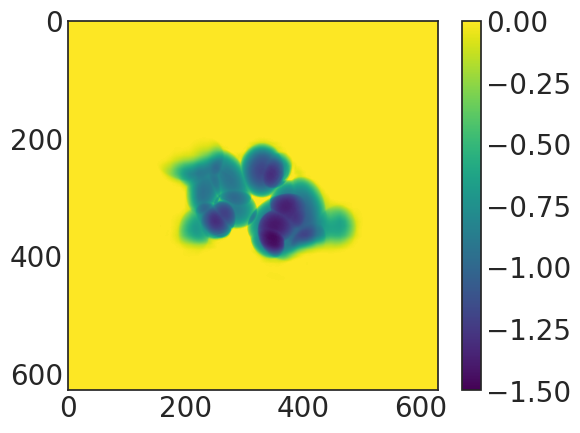

In [ ]:
plt.figure()
plt.imshow(cp.asnumpy(cp.angle(all_object[1][:][:])), cmap='viridis', vmin=-1.5, vmax=0)
plt.colorbar()